In [3]:
###import modules
import numpy as np 
import pandas as pd 
import seaborn as sns 
import datetime
import matplotlib.pyplot as plt 
import scipy.stats as st 

%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble      import RandomForestClassifier
from sklearn.tree          import DecisionTreeClassifier 
from sklearn.svm           import SVC
from sklearn.linear_model  import LogisticRegression
from sklearn.model_selection  import train_test_split 
from sklearn.model_selection  import KFold 
from sklearn.model_selection  import GridSearchCV 
from sklearn.model_selection  import RandomizedSearchCV 
from sklearn.metrics import confusion_matrix,recall_score,classification_report
from sklearn.metrics import precision_recall_curve,auc,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score
import copy
import os
import warnings
warnings.filterwarnings('ignore')

# adjust the font/fig size 
plt.rcParams['font.size'] = 18
#plt.rcParams['figure.figsize'] = (8, 6)

In [4]:
### Helper Functions

# Combine Train/Test data
def get_combined_data(train, test):
    train = Data_train.copy()
    train.drop('Loan_Status', axis=1, inplace=True)
    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop(['index', 'Loan_ID'], inplace=True, axis=1)
#    combined.drop(['index'], inplace=True, axis=1)
    return combined 

In [5]:
### Load dataset
Data_train = pd.read_csv("train_loan.txt", header=0, sep=',') 
Data_test = pd.read_csv("test_loan.txt", header=0, sep=',')   

In [6]:
## save original data
Data_train_original = Data_train.copy()
Data_test_original = Data_test.copy()
targets = Data_train.Loan_Status

## dimensions of train/test sets
print('number of training samples:', Data_train.shape[0])
print('number of test samples:', Data_test.shape[0])
print()
print('number of features:', Data_train.shape[1])

## class distribution
print('class distributions:\n', targets.value_counts(normalize=True))

number of training samples: 614
number of test samples: 367

number of features: 13
class distributions:
 Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64


In [7]:
## merge train/test data into one df
Data_df = get_combined_data(Data_train, Data_test)
no_train_samples = Data_train_original.shape[0]
Data_df = pd.concat([Data_train.iloc[:,:-1], Data_test], axis=0)
Data_df.drop('Loan_ID', axis=1, inplace=True)

## Dataset info
Data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 0 to 366
Data columns (total 11 columns):
Gender               957 non-null object
Married              978 non-null object
Dependents           956 non-null object
Education            981 non-null object
Self_Employed        926 non-null object
ApplicantIncome      981 non-null int64
CoapplicantIncome    981 non-null float64
LoanAmount           954 non-null float64
Loan_Amount_Term     961 non-null float64
Credit_History       902 non-null float64
Property_Area        981 non-null object
dtypes: float64(4), int64(1), object(6)
memory usage: 92.0+ KB


In [8]:
## save combined dataset before processing..
Data_df_original = Data_df.copy()      

## Recover train/test data
train_data = Data_df[:614]    
test_data = Data_df[614:]     

## Exploratory Data Analysis

In [9]:
## select features/predictors
features = [x for x in Data_df.columns]

features_categorical = [x for x in Data_df.columns if Data_df[x].dtype=='object' ]
features_numerical = [x for x in Data_df.columns if Data_df[x].dtype!='object']

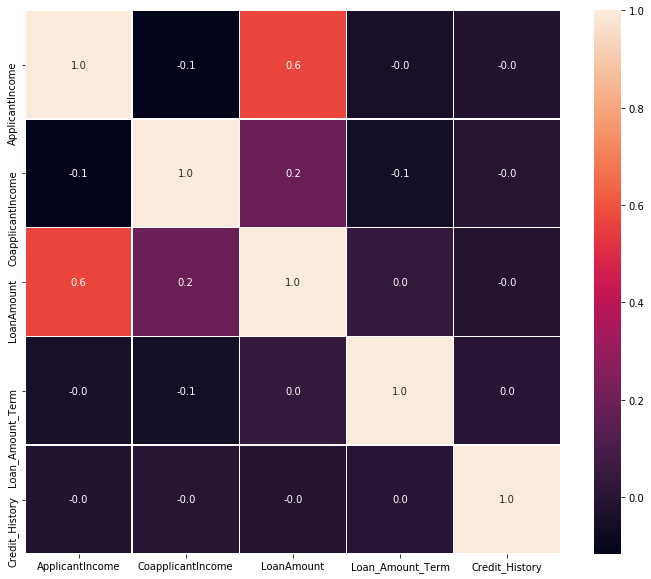

In [16]:
## feat. correlation
f,ax = plt.subplots(figsize=(12, 10))
sns.heatmap(Data_train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

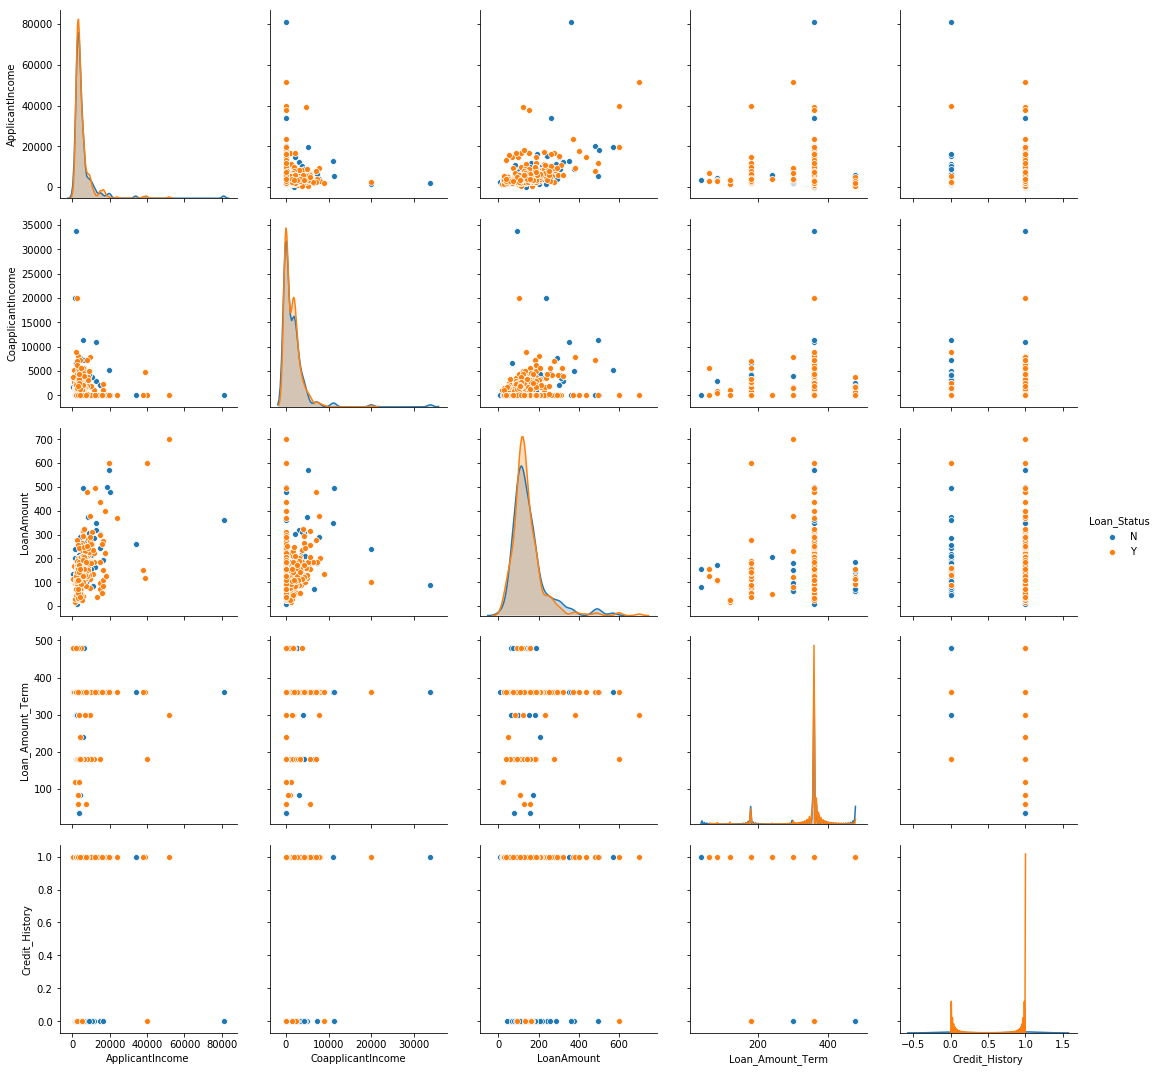

In [10]:
### pairplots w.r.t. loan status
categorical_cols = ['Credit_History', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term','Loan_Status','Credit_History', 'Self_Employed', 'Property_Area']

sns.pairplot(Data_train[cols].dropna(), size=3.0, hue='Loan_Status')

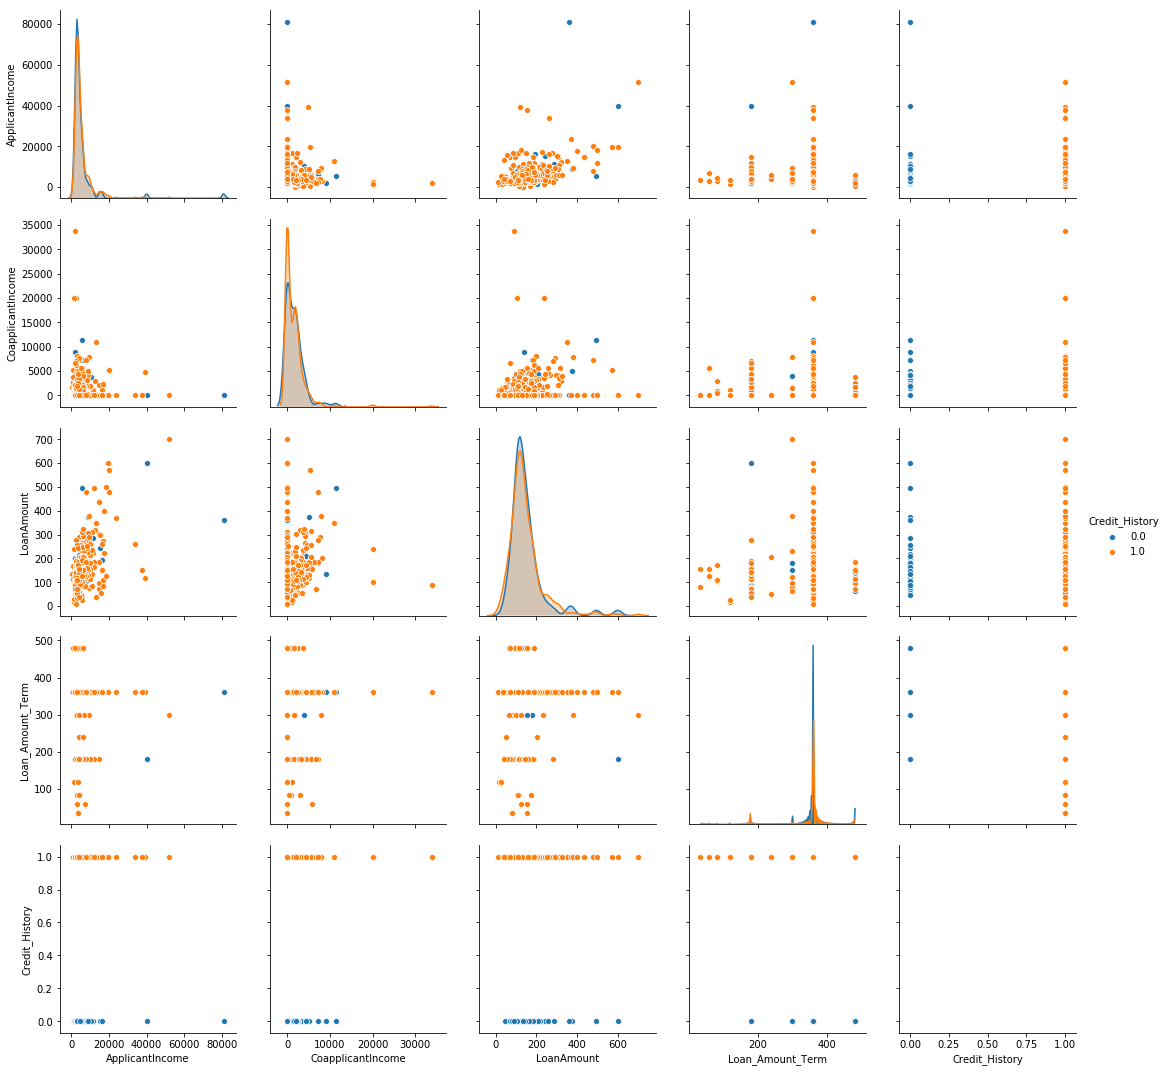

In [19]:
### pairplots w.r.t. Credit History
sns.pairplot(Data_train[cols].dropna(), size=3.0, hue='Credit_History')

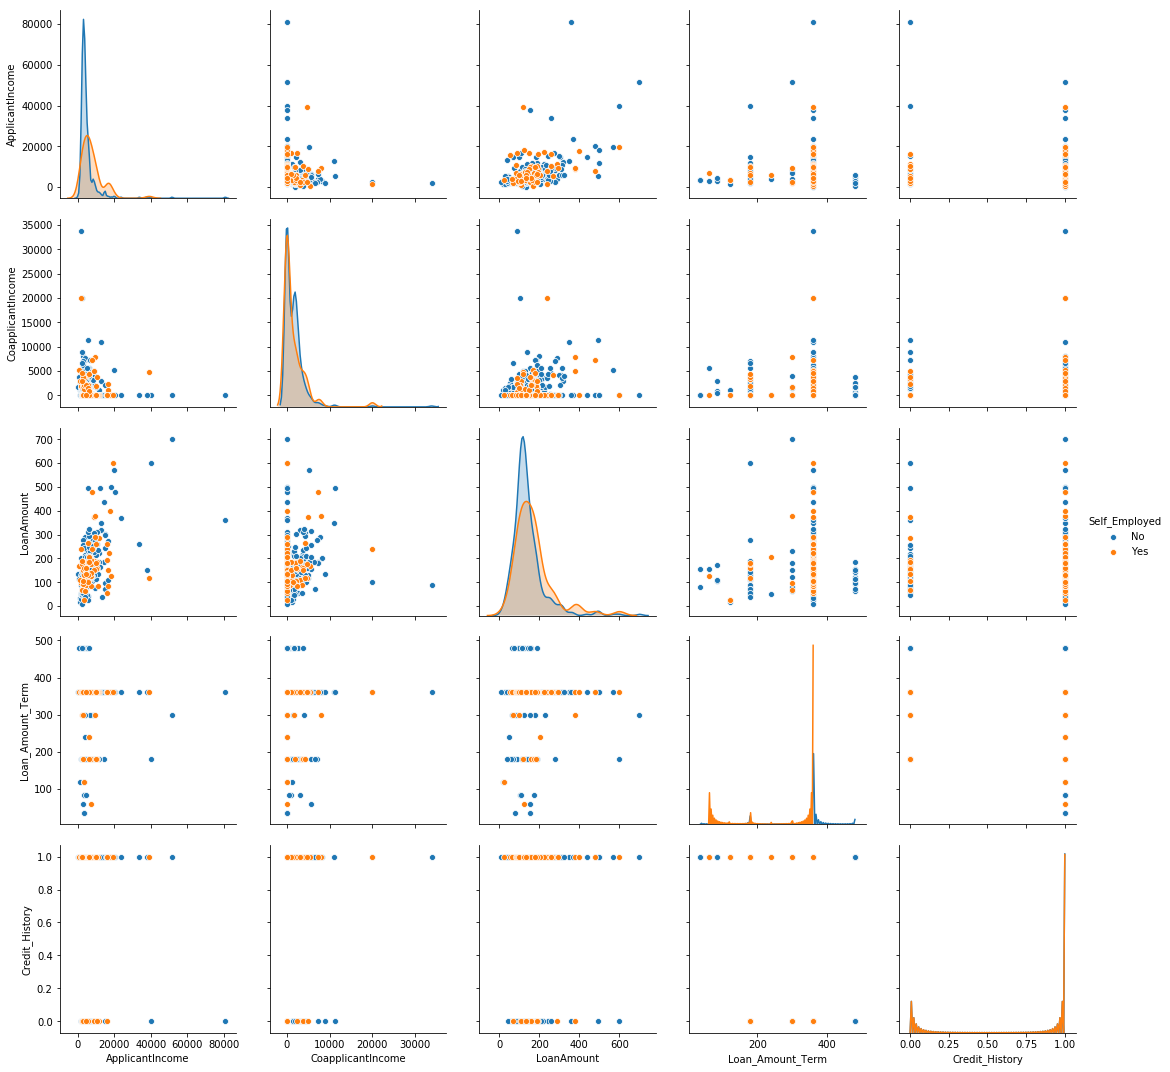

In [20]:
### pairplots w.r.t. Self Employed
sns.pairplot(Data_train[cols].dropna(), size=3.0, hue='Self_Employed')

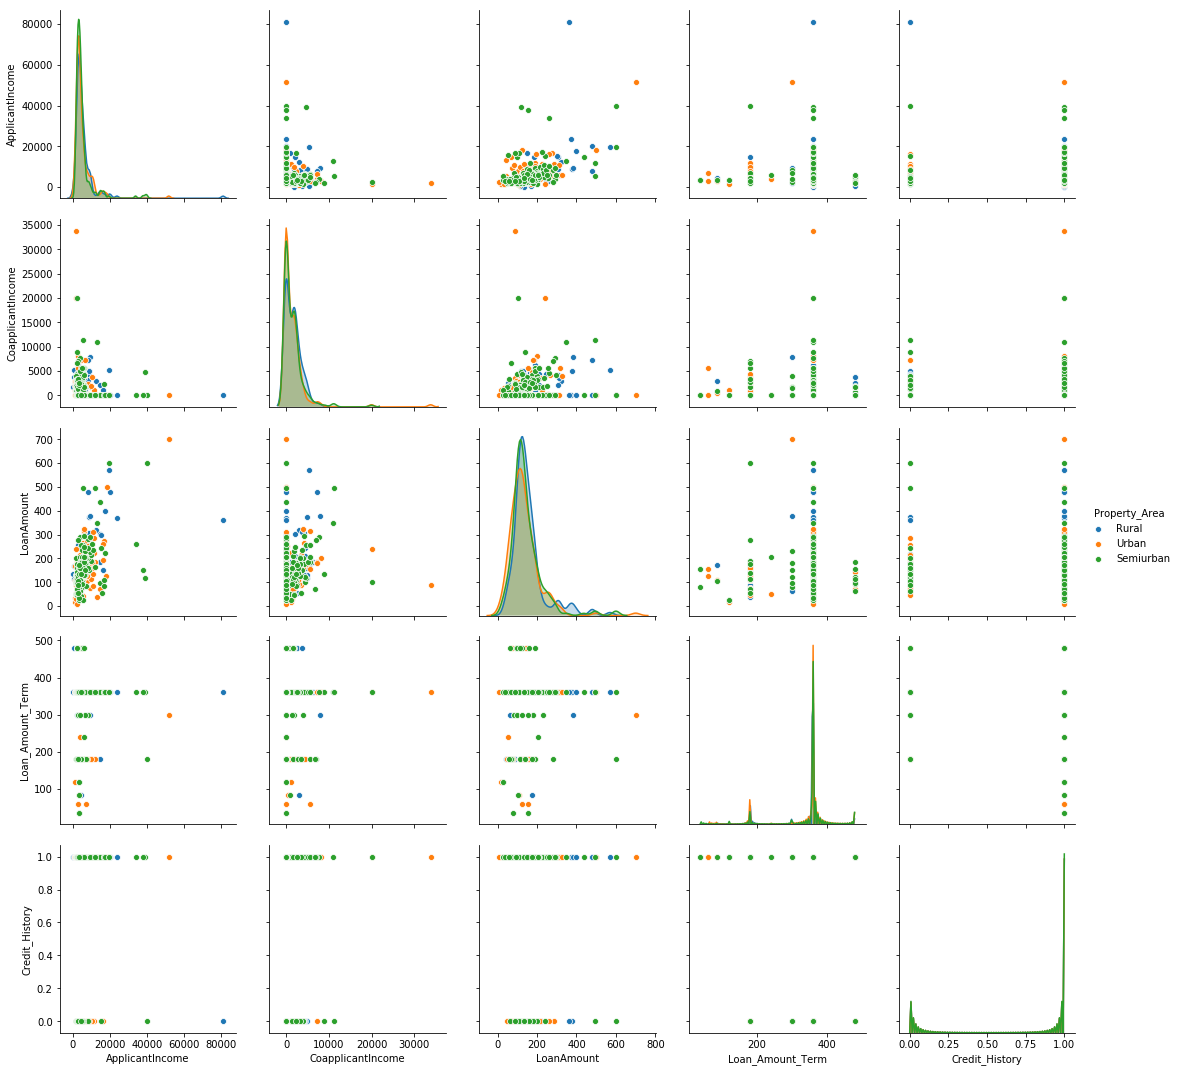

In [21]:
### pairplots w.r.t. Property Area
sns.pairplot(Data_train[cols].dropna(), size=3.0, hue='Property_Area')

### Univariate plots by featexp

                                      Plots for ApplicantIncome                                       


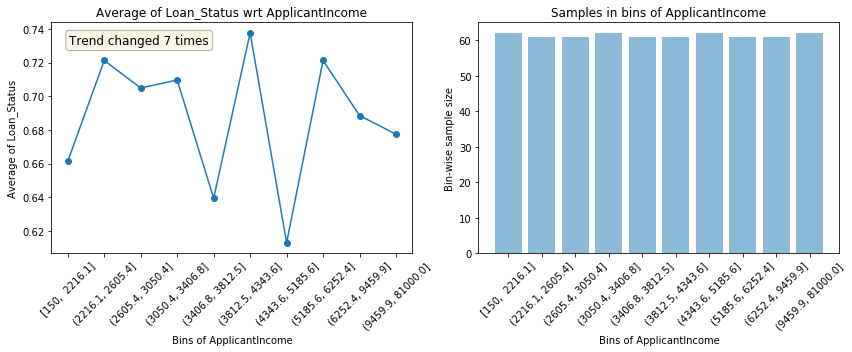

--------------------------------------------------------------------------------------------------------------




In [11]:
import featuretools as ft
import featexp
from featexp import get_univariate_plots

Data_train.replace({'Loan_Status': {'Y':1,'N':0}},  inplace=True)

## Loan status vs. Applicant Income
get_univariate_plots(data=Data_train, target_col='Loan_Status', 
                     features_list=['ApplicantIncome'], bins=10)

                                     Plots for CoapplicantIncome                                      


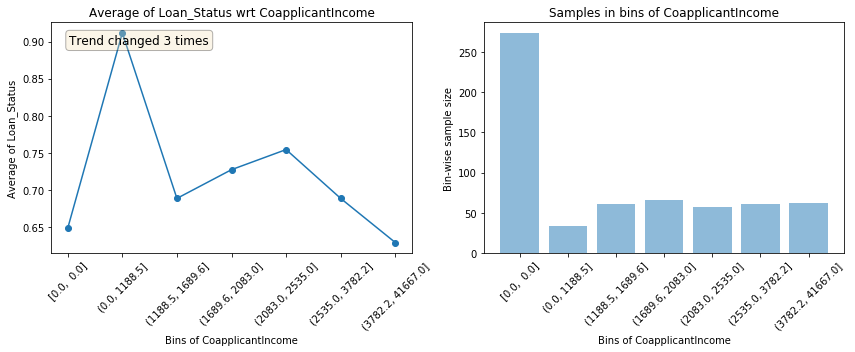

--------------------------------------------------------------------------------------------------------------




In [33]:
## loan status vs. Coapplicant Income
get_univariate_plots(data=Data_train, target_col='Loan_Status', 
                     features_list=['CoapplicantIncome'], bins=10)

                                         Plots for LoanAmount                                         


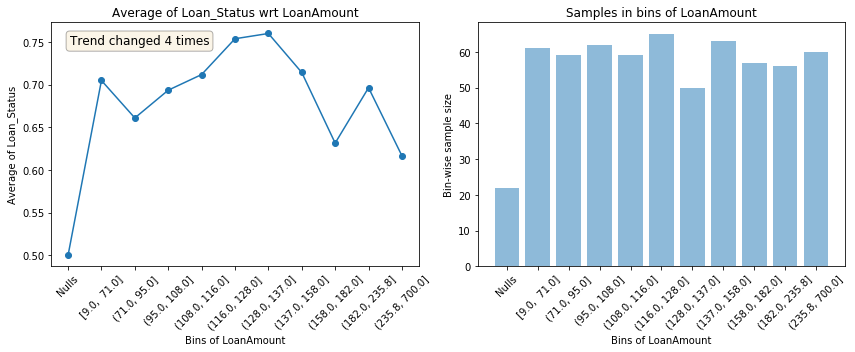

--------------------------------------------------------------------------------------------------------------




In [35]:
## loan status vs. Loan Amount
get_univariate_plots(data=Data_train, target_col='Loan_Status', 
                     features_list=['LoanAmount'], bins=10)

                                      Plots for Loan_Amount_Term                                      


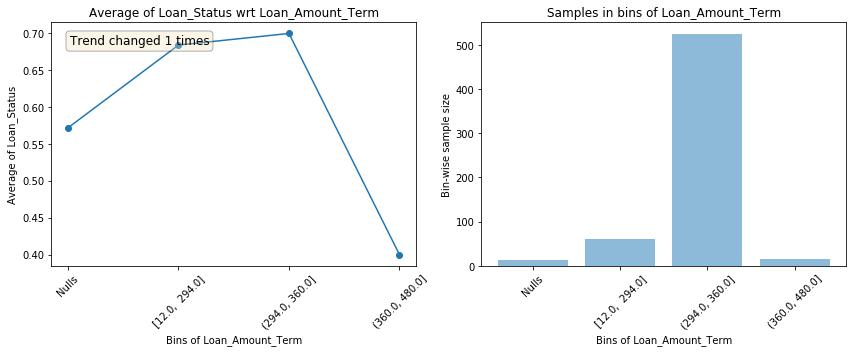

--------------------------------------------------------------------------------------------------------------




In [36]:
## loan status vs. Loan Amount Term
get_univariate_plots(data=Data_train, target_col='Loan_Status', 
                     features_list=['Loan_Amount_Term'], bins=10)

                                       Plots for Credit_History                                       


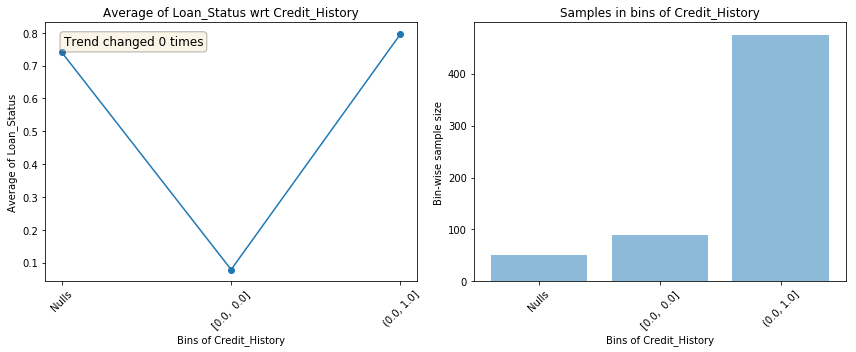

--------------------------------------------------------------------------------------------------------------




In [37]:
## loan status vs. Credit History
get_univariate_plots(data=Data_train, target_col='Loan_Status', 
                     features_list=['Credit_History'], bins=10)

### Identify Noisy features between Train/Test sets


                                      Plots for ApplicantIncome                                       
                                           Train data plots                                           


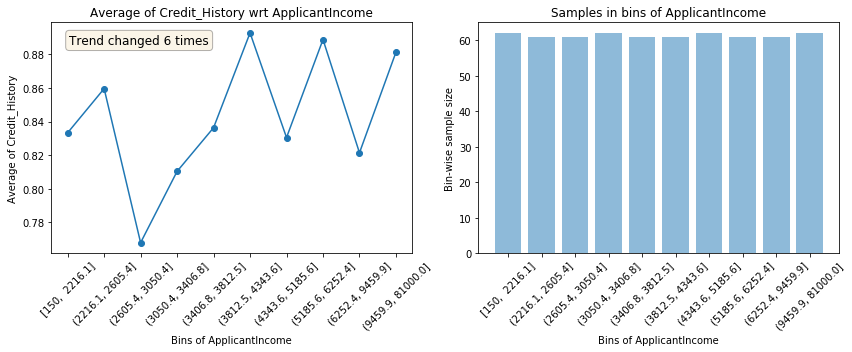

                                           Test data plots                                            


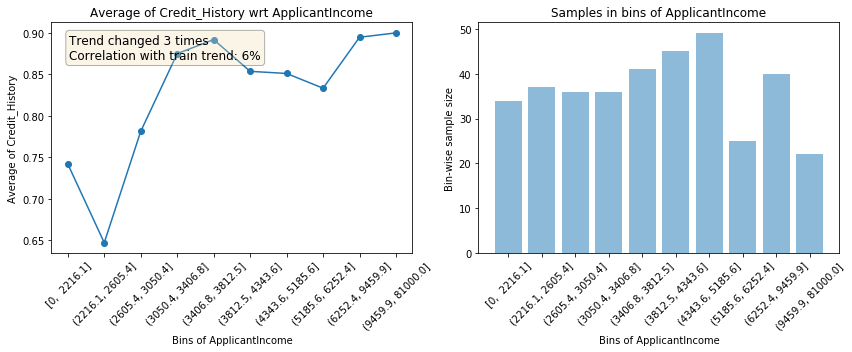

--------------------------------------------------------------------------------------------------------------




In [38]:
## check distribution of Credit wrt Applicant Income
get_univariate_plots(data=Data_train, target_col='Credit_History', 
                     data_test=Data_test, features_list=['ApplicantIncome'])

## check distribution of Applicant Income
#get_univariate_plots(data=Data_train, target_col='ApplicantIncome', 
#                     data_test=Data_test, features_list=['Credit_History'])

In [12]:
from featexp import get_trend_stats
trend_stats = get_trend_stats(data=Data_train.iloc[:,:-1], target_col='Credit_History', data_test=Data_test)


Categorical features ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area'] ignored. Categorical features not supported yet.
Returning stats for all numeric features


In [40]:
print(trend_stats)

,Feature,Trend_changes,Trend_changes_test,Trend_correlation
0,ApplicantIncome,6,3,0.067147
1,CoapplicantIncome,3,5,-0.472168
2,LoanAmount,6,5,0.383012
3,Loan_Amount_Term,1,0,0.945622


### Visualize features

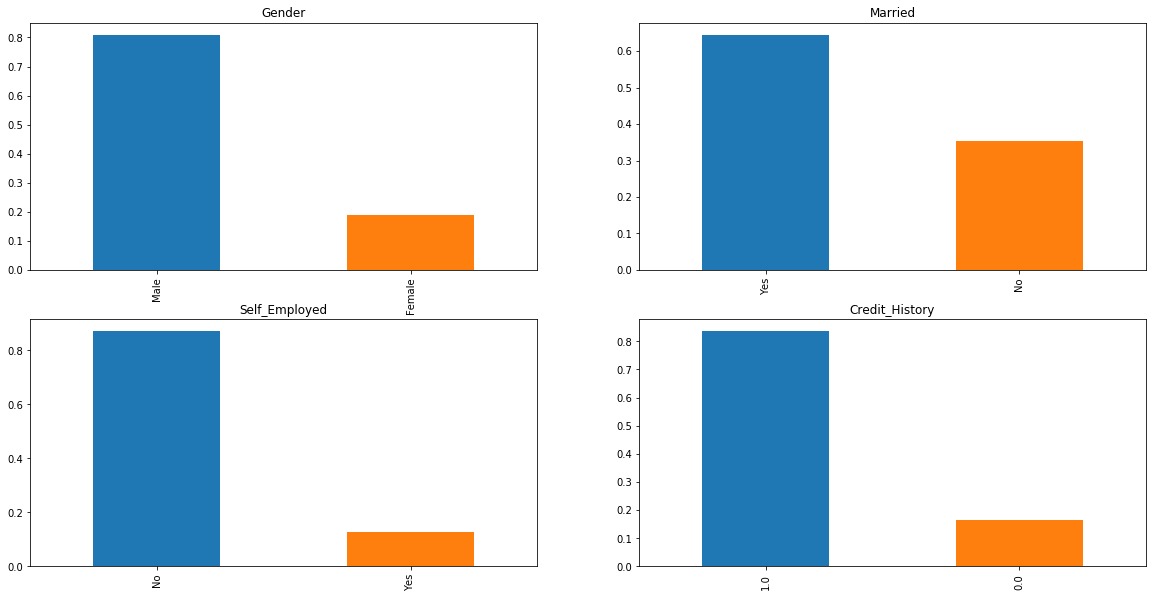

In [41]:
## visualize categorical features
plt.figure(1, figsize=(20,10)) 
plt.subplot(221) 
Data_df['Gender'].value_counts(normalize=True).plot.bar(title='Gender') 
plt.subplot(222) 
Data_df['Married'].value_counts(normalize=True).plot.bar(title='Married') 
plt.subplot(223) 
Data_df['Self_Employed'].value_counts(normalize=True).plot.bar(title= 'Self_Employed') 
plt.subplot(224) 
Data_df['Credit_History'].value_counts(normalize=True).plot.bar(title= 'Credit_History') 
plt.show()

#### Dependents 

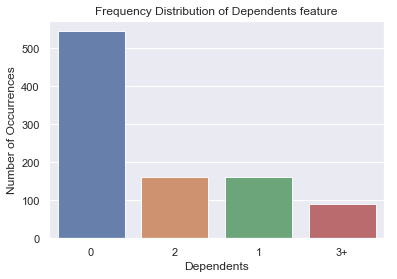

In [42]:
## Dependents 
sns.set(style="darkgrid")
sns.barplot(Data_df_original['Dependents'].value_counts().index, 
            Data_df_original['Dependents'].value_counts().values, alpha=0.9)
plt.title('Frequency Distribution of Dependents feature')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Dependents', fontsize=12)
plt.show()

#### Education and Property Area


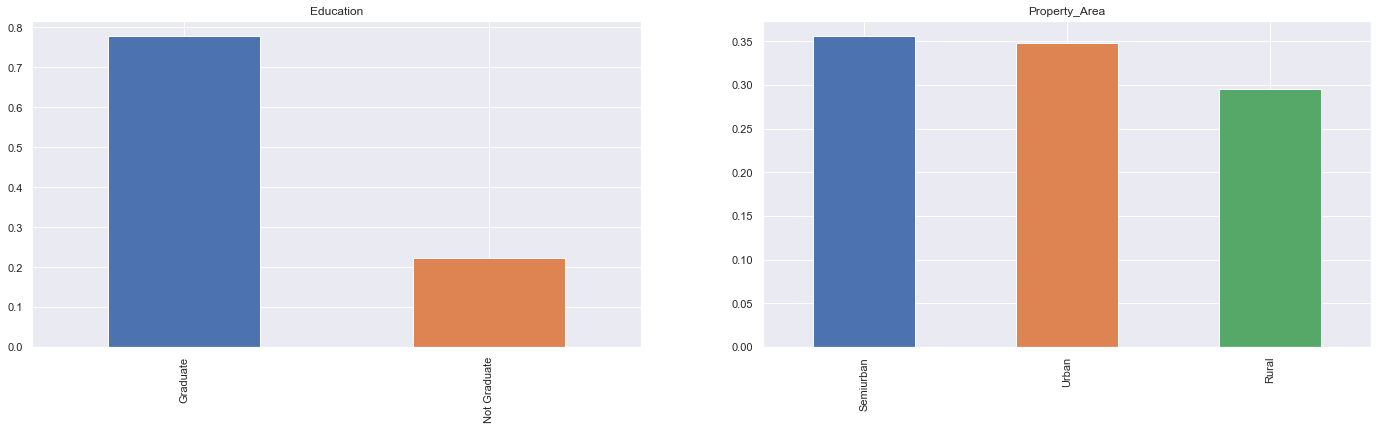

In [43]:
## Education and Property Area
plt.figure(figsize=(24,6)) 
plt.subplot(121) 
Data_df['Education'].value_counts(normalize=True).plot.bar(title='Education') 
plt.subplot(122) 
Data_df['Property_Area'].value_counts(normalize=True).plot.bar(title='Property_Area') 
plt.show()

#### Applicant Income  

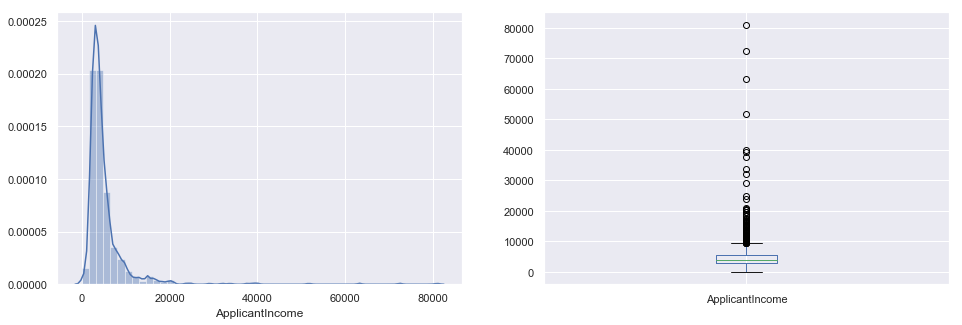

In [44]:
## Applicant Income    

plt.figure(1, figsize=(16,5)) 
plt.subplot(121) 
sns.distplot(Data_df['ApplicantIncome']); 
plt.subplot(122) 
Data_df['ApplicantIncome'].plot.box() 
plt.show()


#### Coapplicant Income  

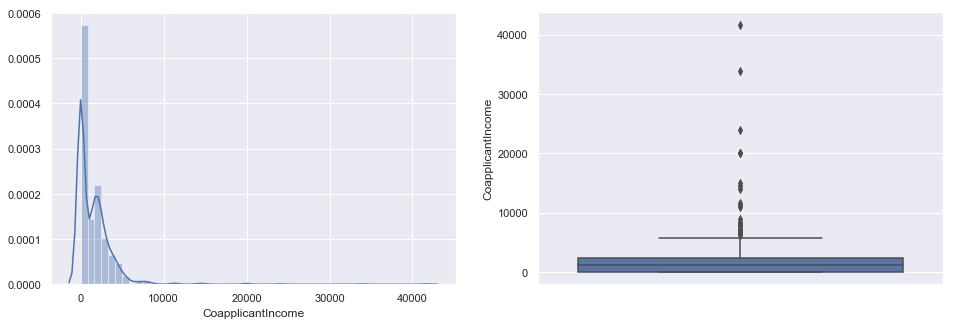

In [45]:
## Coapplicant Income    

plt.figure(figsize=(16,5)) 
plt.subplot(121) 
sns.distplot(Data_df['CoapplicantIncome']); 
plt.subplot(122) 
Data_df['CoapplicantIncome'].plot.box() 
sns.boxplot(y=Data_df['CoapplicantIncome'])
plt.show()

#### Loan Amount 

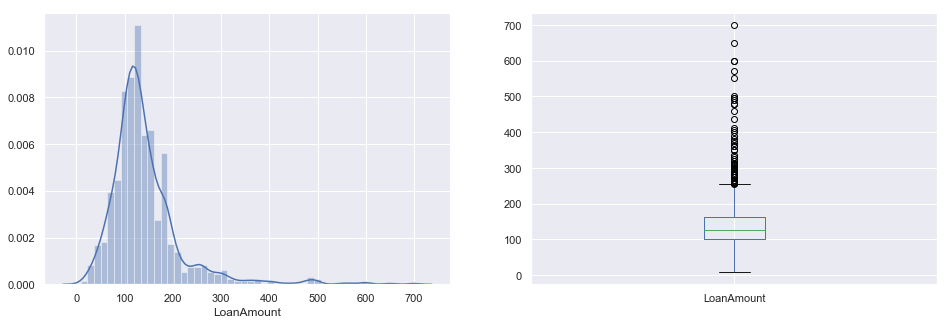

In [46]:
## Loan Amount 

la = Data_df_original['LoanAmount'].dropna()  
plt.figure(figsize=(16,5)) 
plt.subplot(121) 
sns.distplot(la); 
plt.subplot(122) 
la.plot.box() 
plt.show()

## Bivariate Exploratory Data Analysis 

#### Applicant Income vs Education

Text(0.5, 0.98, '')

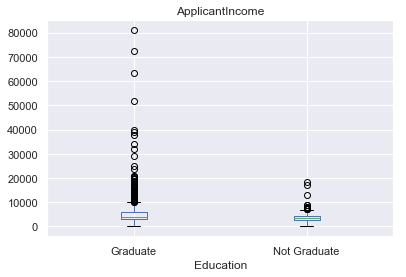

In [47]:
## ApplicantIncome vs Education
Data_df.boxplot(column='ApplicantIncome', by='Education') 
plt.suptitle("")

#### Applicant Income vs Loan Status

Text(0.5, 0.98, '')

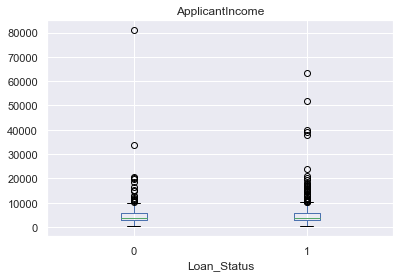

In [49]:
## ApplicantIncome vs Loan_Status
Data_train.boxplot(column='ApplicantIncome', by='Loan_Status') 
plt.suptitle("")

#### Applicant Income by Gender vs Loan status

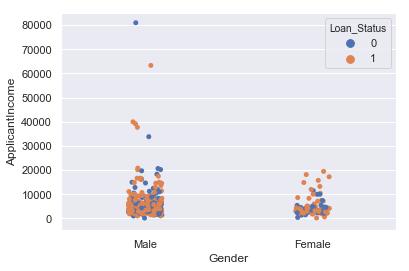

In [50]:
## ApplicantIncome by Gender vs Loan_status
sns.stripplot(x="Gender", y="ApplicantIncome", data=Data_train, 
              hue='Loan_Status', jitter=True)

#### Gender vs Applicant Income < 25000 

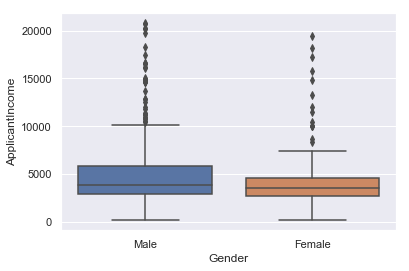

In [51]:
## Gender vs ApplicantIncome < 25000 
sns.boxplot(x='Gender', y='ApplicantIncome',  
            data=Data_train.loc[Data_train.ApplicantIncome < 25000])

In [52]:
## Group Gender wrt Loan status
Data_train.groupby(['Gender'])['Loan_Status'].value_counts(normalize=True)


Gender  Loan_Status
Female  1              0.669643
        0              0.330357
Male    1              0.693252
        0              0.306748
Name: Loan_Status, dtype: float64

#### Loan Amount by Loan Status

Text(0.5, 0.98, '')

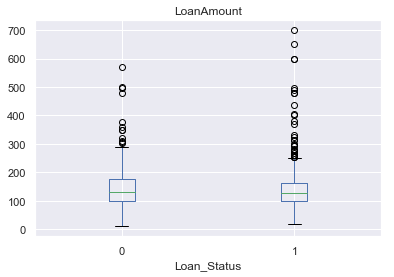

In [56]:
## Loan Amount by Loan_Status
Data_train.boxplot(column='LoanAmount', by='Loan_Status') 
plt.suptitle("")


#### Loan Amount by Property Area

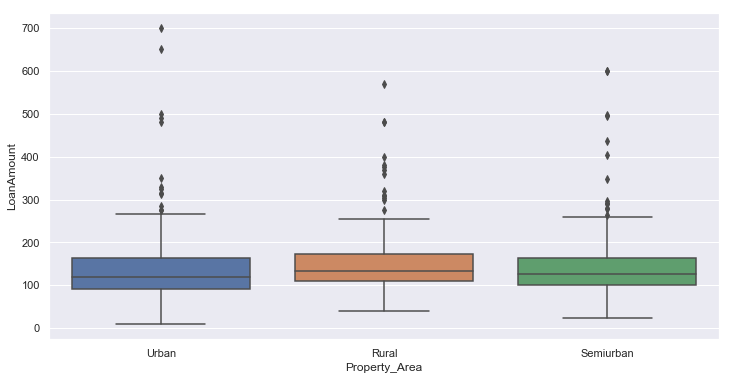

In [57]:
## Loan Amount by Property_Area

plt.figure(figsize = (12, 6))
sns.boxplot(x='Property_Area', y='LoanAmount', data=Data_train)

#### Credit history vs Gender  hue  Loan status 

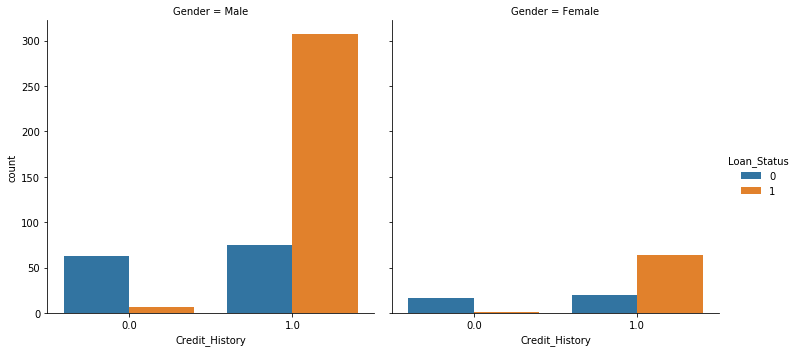

In [13]:
# Credit history vs Gender \\ Loan status 
sns.factorplot(x="Credit_History", hue="Loan_Status", col="Gender", 
               data=Data_train, kind="count")

#### Credit history vs Education hue Loan status 

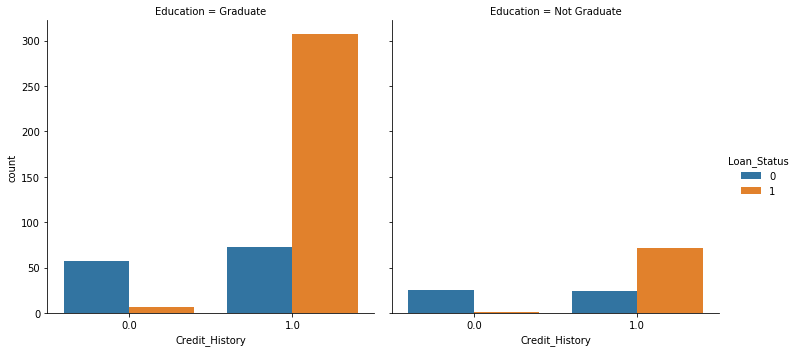

In [14]:
## Credit history vs Education \\ Loan status 
sns.factorplot(x="Credit_History", hue="Loan_Status", col="Education", 
               data=Data_train, kind="count")

####  Group Married, Gender wrt Loan Status

In [15]:
###  Married
pd.crosstab(Data_train.Married, Data_train.Loan_Status)
Data_train.groupby(['Gender'])['Married'].value_counts(normalize=True)


Gender  Married
Female  No         0.720721
        Yes        0.279279
Male    Yes        0.733060
        No         0.266940
Name: Married, dtype: float64

#### Married by Gender  hue Loan status

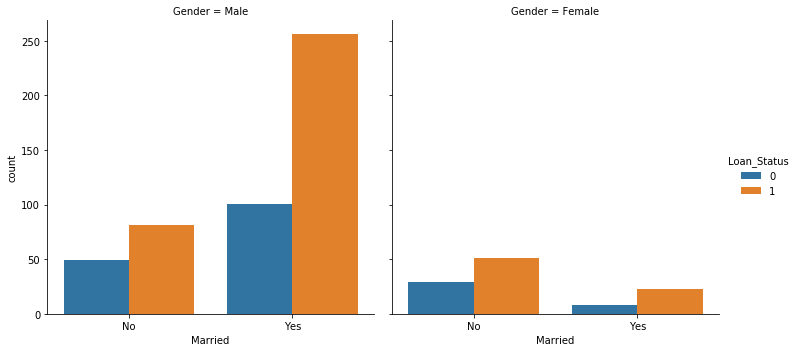

In [16]:
## Married vs Gender \\ Loan status 
sns.factorplot(x="Married", hue="Loan_Status", col="Gender", 
               data=Data_train, kind="count")

#### Dependents vs Loan Status

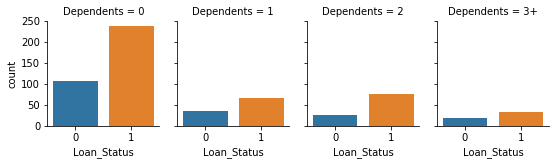

In [17]:
Data_train.groupby(['Dependents'])['Loan_Status'].value_counts(normalize=True)
sns.factorplot("Loan_Status", col="Dependents", col_wrap=4, 
               data=Data_train, kind="count", size=2.4, aspect=.8)

#### Dependents by Gender \\ Married \\ Property area

In [18]:
# Dependents by Gender \\ Married \\ Property_area
Data_df.groupby(['Gender', 'Married', 'Property_Area'])['Dependents'].value_counts(normalize=True)

Gender  Married  Property_Area  Dependents
Female  No       Rural          0             0.774194
                                1             0.161290
                                3+            0.064516
                 Semiurban      0             0.693878
                                1             0.224490
                                2             0.061224
                                3+            0.020408
                 Urban          0             0.800000
                                1             0.100000
                                3+            0.075000
                                2             0.025000
        Yes      Rural          0             0.700000
                                1             0.300000
                 Semiurban      0             0.612903
                                2             0.193548
                                1             0.129032
                                3+            0.064516
                 Urban

####  Education by Loan status

Education     Loan_Status
Graduate      1              0.708333
              0              0.291667
Not Graduate  1              0.611940
              0              0.388060
Name: Loan_Status, dtype: float64

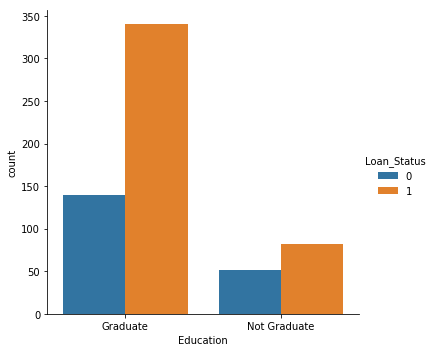

In [19]:
##  Education by Loan_status
sns.factorplot(x="Education", hue="Loan_Status", data=Data_train, kind="count")
Data_train.groupby(['Education'])['Loan_Status'].value_counts(normalize=True)


#### Self Employed by Loan status

In [20]:
## Self_Employed by Loan_status
Data_train.groupby(['Self_Employed'])['Loan_Status'].value_counts(normalize=True)


Self_Employed  Loan_Status
No             1              0.686000
               0              0.314000
Yes            1              0.682927
               0              0.317073
Name: Loan_Status, dtype: float64

#### Group Self Employed 

In [21]:
# Self_Employed by Education\\Married\\Dependents\\..
Data_train.groupby(['Education', 'Married', 'Dependents', 
               'Gender', 'Property_Area'])['Self_Employed'].apply(lambda x: x.mode())

Education     Married  Dependents  Gender  Property_Area   
Graduate      No       0           Female  Rural          0     No
                                           Semiurban      0     No
                                           Urban          0     No
                                   Male    Rural          0     No
                                           Semiurban      0     No
                                           Urban          0     No
                       1           Female  Rural          0     No
                                           Semiurban      0     No
                                           Urban          0     No
                                   Male    Rural          0    Yes
                                           Semiurban      0     No
                                           Urban          0     No
                       2           Female  Urban          0     No
                                   Male    Rural          0     No
  

#### Applicant Income

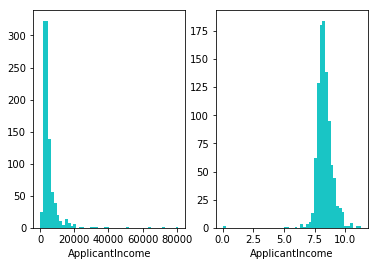

In [22]:
### Applicant Income hist
plt.subplot(121)
sns.distplot(Data_df['ApplicantIncome'], kde=False, color='c', 
             hist_kws={'alpha': 0.9})
plt.subplot(122)
sns.distplot(np.log1p(Data_df['ApplicantIncome']), kde=False, color='c', 
             hist_kws={'alpha': 0.9})
plt.show()


Text(0, 0.5, 'LoanAmount')

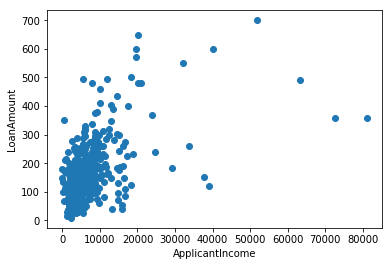

In [24]:
plt.scatter(Data_df['ApplicantIncome'], Data_df['LoanAmount'])
plt.xlabel('ApplicantIncome')
plt.ylabel('LoanAmount')

#### Coapplicant Income

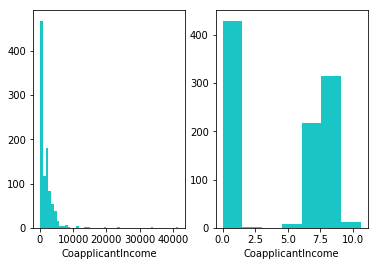

In [25]:
## CoapplicantIncome
plt.figure()
plt.subplot(121)
sns.distplot(Data_df['CoapplicantIncome'], kde=False, color='c', 
             hist_kws={'alpha': 0.9})
plt.subplot(122)
sns.distplot(np.log1p(Data_df['CoapplicantIncome']), kde=False, color='c', 
             hist_kws={'alpha': 0.9})
plt.show()

#### Loan amount

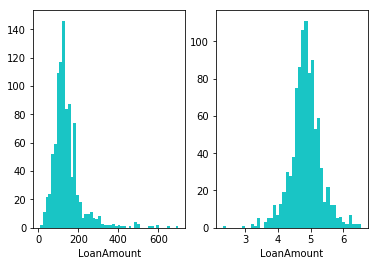

In [28]:
## Loan_amount hist. 
plt.figure()
plt.subplot(121)
sns.distplot(Data_df['LoanAmount'].dropna(), kde=False, color='c', hist_kws={'alpha': 0.9})
plt.subplot(122)
sns.distplot(np.log1p(Data_df['LoanAmount'].dropna()), kde=False, color='c', hist_kws={'alpha': 0.9})
plt.show()


In [31]:
# avg loan amount by Education\\Gender\\Employment
Data_df.groupby(['Education', 'Gender', 'Self_Employed'])['LoanAmount'].median()

Education     Gender  Self_Employed
Graduate      Female  No               112.0
                      Yes              141.5
              Male    No               134.0
                      Yes              150.0
Not Graduate  Female  No               112.0
                      Yes              131.5
              Male    No               115.0
                      Yes              130.0
Name: LoanAmount, dtype: float64

#### Explore Loan Amount Term

In [34]:
Data_df['Loan_Amount_Term'].value_counts()

360.0    823
180.0     66
480.0     23
300.0     20
240.0      8
84.0       7
120.0      4
36.0       3
60.0       3
12.0       2
350.0      1
6.0        1
Name: Loan_Amount_Term, dtype: int64

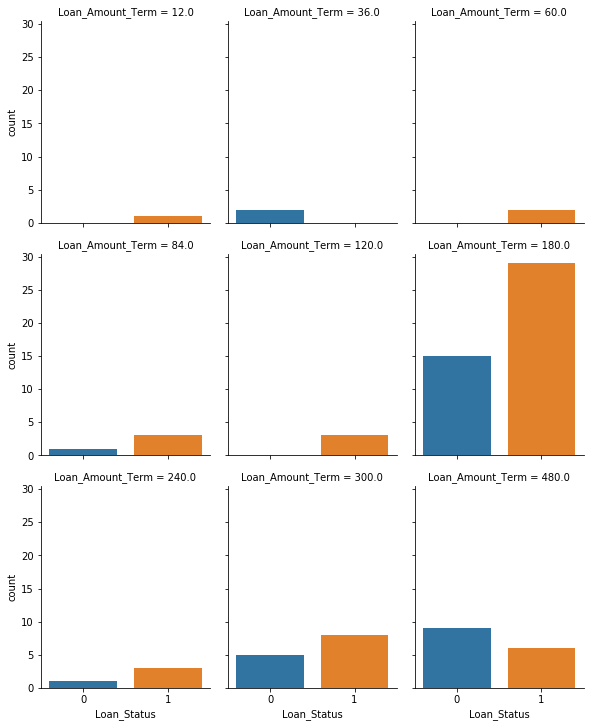

In [35]:
## Loan_Amount_Term
sns.factorplot("Loan_Status", col="Loan_Amount_Term", col_wrap=3,
               data=Data_train.loc[Data_train.Loan_Amount_Term !=360.], kind="count", size=3.4, aspect=.8)

#### Credit History

In [36]:
#%% Credit_history
Data_df.Credit_History.value_counts()
#Data_train.Credit_History.value_counts()

#Data_df.groupby(['Education', 'Self_Employed', 'Property_Area', 'ApplicantInc_group'])['Credit_History'].apply(lambda x: x.mode())
#Data_df.groupby(['Education', 'Self_Employed', 'ApplicantInc_group'])['Credit_History'].apply(lambda x: x.mode())

1.0    754
0.0    148
Name: Credit_History, dtype: int64

#### Explore Property Area wrt Loan status

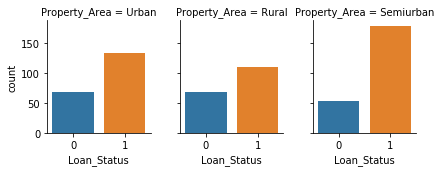

In [37]:
## Property_Area
sns.factorplot('Loan_Status', col='Property_Area', col_wrap=3, 
              data=Data_train, kind='count', size=2.5, aspect=.8)

### Check missing values

In [43]:
## Check missing values
print('Check missing values...', 
      Data_df.apply(lambda x: sum(x.isnull())), sep='\n', end='\n')

print()
print('Check missing values Train set...', 
      Data_train.apply(lambda x: sum(x.isnull())), sep='\n', end='\n')

print()
print('Check missing values Test set...', 
      Data_test.apply(lambda x: sum(x.isnull())),sep='\n', end='\n')

Check missing values...
Gender               24
Married               3
Dependents           25
Education             0
Self_Employed        55
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           27
Loan_Amount_Term     20
Credit_History       79
Property_Area         0
dtype: int64

Check missing values Train set...
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Check missing values Test set...
Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64


### Imputation (Method-1)

##### Fill in Categorical: {Gender (24) Married (3) Dependents (25) Self_Employed (55)}

In [45]:
## Fill Gender
#-------------
Data_df['Gender'].fillna(Data_df['Gender'].mode()[0], inplace=True)
#Data_df['Gender'] = Data_df['Gender'].astype(np.int) 

In [47]:
## Fill Married
#-------------
Data_df['Married'].fillna(Data_df['Married'].mode()[0], inplace=True)
#Data_df['Married']=Data_df['Married'].astype(np.int)

In [49]:
## Fill Dependents
#-------------
Data_df['Dependents'].fillna(Data_df['Dependents'].mode()[0], inplace=True)
#Data_df['Dependents'] = Data_df['Dependents'].astype(np.int)

In [51]:
## Fill Self_Employed
#---------------------
Data_df['Self_Employed'].fillna(Data_df['Self_Employed'].mode()[0], inplace=True)
#Data_df['Self_Employed'] = Data_df['Self_Employed'].astype(np.int)

##### Fill in Numerical 

In [53]:
## Fill LoanAmount
#-----------------
Data_df['LoanAmount'].fillna(Data_df['LoanAmount'].median(), inplace=True)

In [55]:
## Fill Loan Amount Term
#-----------------------
Data_df['Loan_Amount_Term'].fillna(Data_df['Loan_Amount_Term'].mode()[0], inplace=True)

In [57]:
# Fill Credit_history 
#-------------------
Data_df['Credit_History'].fillna(Data_df['Credit_History'].mode()[0], inplace=True)
Data_df['Credit_History'] = Data_df['Credit_History'].astype(np.int)
## Or fill NaNs with '2'
#Data_df['Credit_History'].fillna(2, inplace=True)   
#Data_df['Credit_History'] = Data_df['Credit_History'].astype(str)

In [58]:
print('Check missing values...', 
      Data_df.apply(lambda x: sum(x.isnull())), sep='\n', end='\n')

Check missing values...
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64


### Feature Engineering


In [60]:
### New feature: Total_Income
Data_df['Total_Income'] = Data_df['ApplicantIncome'] + Data_df['CoapplicantIncome']
# log tramsform 
Data_df['Total_Income_log'] = np.log1p(Data_df['Total_Income']) 


In [61]:
### New feature: Debt_Income_Ratio
Data_df['Debt_Income_Ratio'] = Data_df['Total_Income'] / Data_df['LoanAmount']
# log tramsform 
Data_df['Debt_Income_Ratio_log'] = np.log1p(Data_df['Debt_Income_Ratio']) 

In [62]:
### New feature: EMI
Data_df['EMI'] = Data_df['LoanAmount'] / Data_df['Loan_Amount_Term']
# log tramsform
Data_df['EMI_log'] = np.log1p(Data_df['EMI']) 

#### Skew check in numerical features

In [66]:
features_numerical = Data_df.dtypes[Data_df.dtypes != "object"].index

skewed_feats = Data_df[features_numerical].apply(lambda x: st.skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skew_df = pd.DataFrame({'Skew' :skewed_feats})
skew_df.head(10)


Skew in numerical features: 



,Skew
EMI,16.937704
ApplicantIncome,7.076120
CoapplicantIncome,6.833639
Total_Income,6.033209
Debt_Income_Ratio,5.770783
EMI_log,5.425406
LoanAmount,2.760264
Debt_Income_Ratio_log,1.586090
Total_Income_log,1.122110
Credit_History,-1.950910


### Apply a Box Cox Transformation

There are 11 skewed numerical features to Box Cox transform


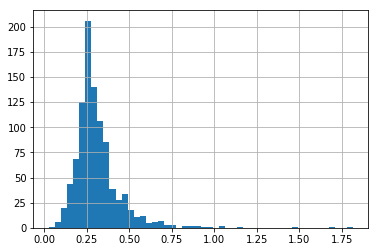

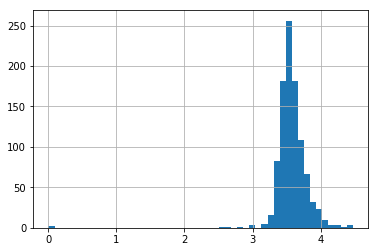

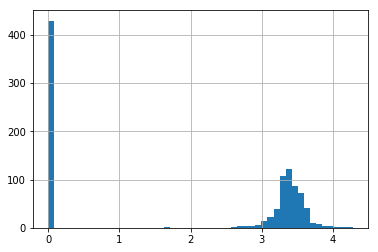

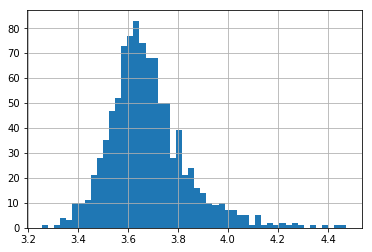

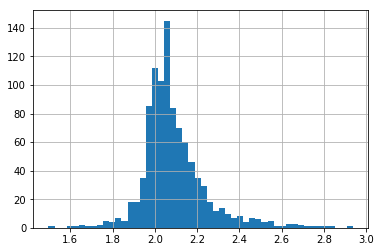

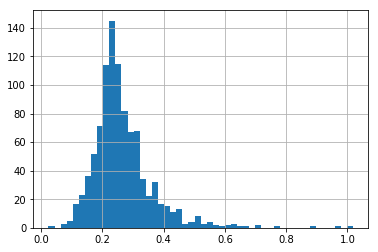

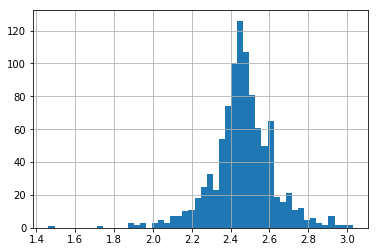

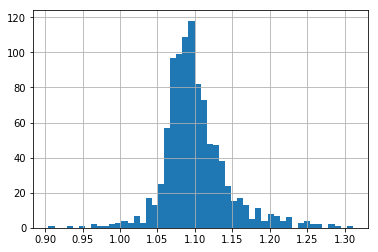

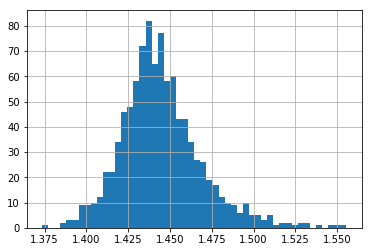

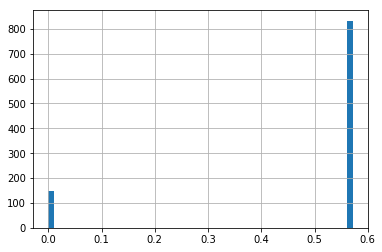

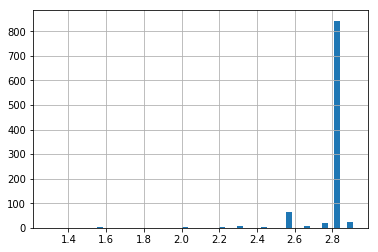

In [69]:
### Box Cox Transformation
from scipy.special import boxcox1p

skew_df = skew_df[abs(skew_df) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skew_df.shape[0]))

#skewed_features = skew_df.index
l = 0.15   # l=0 --> log1p
for feature in skew_df.index:
    Data_df[feature] = boxcox1p(Data_df[feature], l)
    
#plot them...
for feature in skew_df.index:
    plt.figure()
    Data_df[feature].hist(bins=50)

#### Log vs BoxCox Transformation

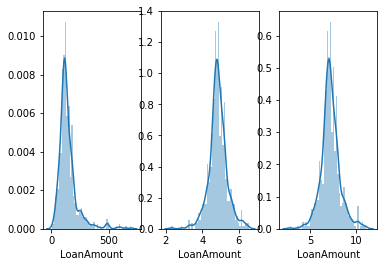

In [72]:
### Loan amount - log vs BoxCox 

plt.figure()   #figsize=(24,12)
plt.subplot(131)
sns.distplot(Data_train['LoanAmount'], bins=50, norm_hist=True)
plt.subplot(132)
sns.distplot(np.log1p(Data_train['LoanAmount']),bins=50 )
plt.subplot(133)
sns.distplot(boxcox1p(Data_train['LoanAmount'], l), bins=50)


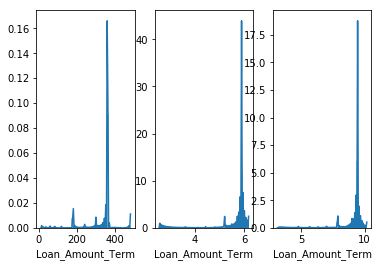

In [73]:
### Loan Amount Term - log vs BoxCox

plt.figure()   #figsize=(24,12)
plt.subplot(131)
sns.distplot(Data_train['Loan_Amount_Term'], bins=50, norm_hist=True)
plt.subplot(132)
sns.distplot(np.log1p(Data_train['Loan_Amount_Term']),bins=50 )
plt.subplot(133)
sns.distplot(boxcox1p(Data_train['Loan_Amount_Term'], l), bins=50)


In [76]:
## DROP COLS
drop_cols = ['Loan_Amount_Term',
             'LoanAmount',
             'Total_Income',
             'Debt_Income_Ratio',
             'EMI']
             
Data_df = Data_df.drop(drop_cols, axis=1)
           
# save a copy...
Data_df_proc = Data_df.copy() 

### ENCODING 

In [77]:
Data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 0 to 366
Data columns (total 12 columns):
Gender                   981 non-null object
Married                  981 non-null object
Dependents               981 non-null object
Education                981 non-null object
Self_Employed            981 non-null object
ApplicantIncome          981 non-null float64
CoapplicantIncome        981 non-null float64
Credit_History           981 non-null float64
Property_Area            981 non-null object
Total_Income_log         981 non-null float64
Debt_Income_Ratio_log    981 non-null float64
EMI_log                  981 non-null float64
dtypes: float64(6), object(6)
memory usage: 99.6+ KB


In [79]:
# LabelEncoding with Scikit
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

Data_df['Gender_code'] = le.fit_transform(Data_df['Gender']) 
Data_df['Married_code'] = le.fit_transform(Data_df['Married']) 
Data_df['Education_code'] = le.fit_transform(Data_df['Education']) 
Data_df['Self_Employed_code'] = le.fit_transform(Data_df['Self_Employed']) 


In [80]:
# Encode Dependents with dummies

Data_df['Dependents'] = Data_df['Dependents'].str.rstrip('+')

dummy_dep = pd.get_dummies(Data_df['Dependents'], prefix='Dependents')
Data_df = pd.concat([Data_df, dummy_dep], axis=1)

In [81]:
# Encode Property_Area

dummy_area = pd.get_dummies(Data_df['Property_Area'], prefix='Property_Area')
Data_df = pd.concat([Data_df, dummy_area], axis=1)

In [82]:
# Encode Credit_history
 
dummy_credit = pd.get_dummies(Data_df['Credit_History'], prefix='Credit_History')
Data_df = pd.concat([Data_df, dummy_credit], axis=1)


In [83]:
# DROP original categorical features
Data_df.drop('Married', axis=1, inplace=True)
Data_df.drop('Gender', axis=1, inplace=True)
Data_df.drop('Education', axis=1, inplace=True)
Data_df.drop('Self_Employed', axis=1, inplace=True)
Data_df.drop('Dependents', axis=1, inplace=True)
Data_df.drop('Property_Area', axis=1, inplace=True)
Data_df.drop('Credit_History', axis=1, inplace=True)

#### Save df as .csv file

In [84]:
#%% Save as .csv file
data_file_name = 'LoanData_df'
Data_df.to_csv((('%s.csv') % (data_file_name)), index=False)